In [2]:
!unzip  dataset.zip
import torch 
import torchvision.models as models
import numpy as np
import json


Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/imagenet_class_index.json  
   creating: dataset/data/
  inflating: dataset/data/tiger.jpg  
  inflating: dataset/data/common_newt.jpg  
  inflating: dataset/data/goldfish.jpg  
  inflating: dataset/data/plate.jpg  
  inflating: dataset/data/giant_panda.jpg  


In [0]:
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from carlini_attack import carlini_l2_attack

In [0]:
# idx2label returns label for each index for the 1000
# classes imagenet classifier
# label2idx is a dictionary containing label as key and index as value for imagenet classes
class_idx = json.load(open("dataset/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
label2idx = {}
for k in range(len(class_idx)):
  label2idx[class_idx[str(k)][1]] = k

# allow use of gpu 
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")



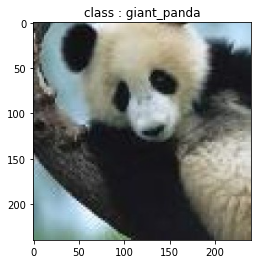

In [5]:
def imshow(img, title):
    plt.imshow(img)
    plt.title(title)
plt.figure()
# show giant panda image
imshow(io.imread('dataset/data/giant_panda.jpg'),'class : giant_panda')



In [6]:
# write custom dataloader class
import os
from PIL import Image
from os import listdir
helper_list = listdir('dataset/data/')
if '.ipynb_checkpoints' in helper_list:
  helper_list.remove('.ipynb_checkpoints')
class L2_attack_dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform, custom_label):

        self.root_dir = root_dir
        self.transform = transform
        self.custom_label = custom_label

    def __len__(self):
        return len(helper_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir, helper_list[idx])
        image = io.imread(img_name)
        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)
        return {'image' : image , 'name' : helper_list[idx][:-4]}
print(helper_list)

['goldfish.jpg', 'plate.jpg', 'common_newt.jpg', 'tiger.jpg', 'giant_panda.jpg']


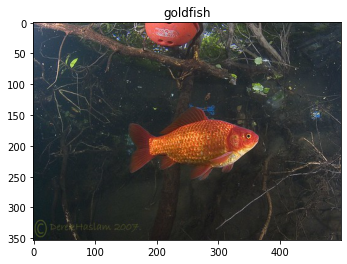

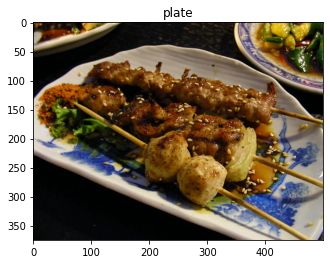

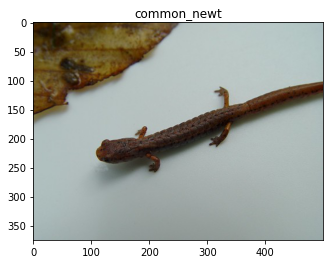

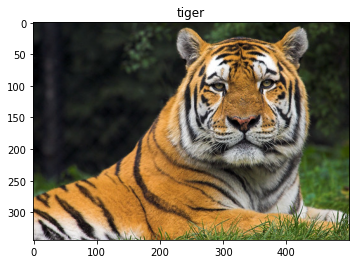

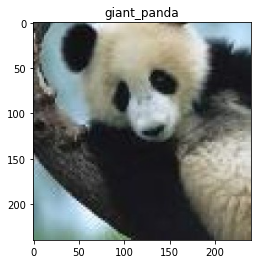

In [7]:
# original images showing without resizing them according to inception 3 model
attack_dataset =   L2_attack_dataset(root_dir='dataset/data/', transform = None, custom_label = idx2label)
fig = plt.figure()

for i in range(len(attack_dataset)):
    sample = attack_dataset[i]
    # print(i, sample.shape)
    imshow(sample['image'], sample['name'])
    plt.show()

  

In [8]:
model = models.inception_v3(pretrained=True).to(device)
# In[11]:


print("True Image & Predicted Label")

model.eval()



Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth



True Image & Predicted Label


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [11]:
# dataset obtained after applying transformation
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])
transformed_dataset = L2_attack_dataset(root_dir='dataset/data/', transform = transform, custom_label = idx2label)
normal_loader = DataLoader(transformed_dataset, batch_size=1, shuffle=False)
for i, images in enumerate(normal_loader):
  image = images['image']
  image_name = images['name']
  print('new test case')
  print('Original label of the image : ', image_name)
  image = image.to(device)
  # print(image.shape)
  outputs = model(image)
    
  _, pre = torch.max(outputs.data, 1)
  # prints the original label as predicted by the model
  print('Label as predicted by the model : ',idx2label[pre])
  

new test case
Original label of the image :  ['goldfish']
Label as predicted by the model :  goldfish
new test case
Original label of the image :  ['plate']
Label as predicted by the model :  plate
new test case
Original label of the image :  ['common_newt']
Label as predicted by the model :  common_newt
new test case
Original label of the image :  ['tiger']
Label as predicted by the model :  tiger
new test case
Original label of the image :  ['giant_panda']
Label as predicted by the model :  giant_panda


In [0]:

import torch.optim as optim
import torch.nn as nn
def carlini_l2_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, max_iter=1000, learning_rate=0.01) :

    images = images.to(device)     
    labels = labels.to(device)

    # Define f-function
    def f(x) :

        outputs = model(x)
        one_hot_labels = torch.eye(len(outputs[0]))[labels].to(device)

        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.bool())
        
        # If targeted, optimize for making the other class most likely 
        if targeted :
            return torch.clamp(i-j, min=-kappa)
        
        # If untargeted, optimize for making the other class most likely 
        else :
            return torch.clamp(j-i, min=-kappa)
    
    w = torch.zeros_like(images).to(device)
    w.detach_()
    w.requires_grad=True

    optimizer = optim.Adam([w], lr=learning_rate)

    prev = 1e10

    
    for step in range(max_iter) :

        a = 1/2*(nn.Tanh()(w) + 1)

        loss1 = nn.MSELoss(reduction='sum')(a, images)
        loss2 = torch.sum(c*f(a))

        cost = loss1 + loss2

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Early Stop when loss does not converge.
        if step % (max_iter//10) == 0 :
            if cost > prev :
                return a
            prev = cost
        
        print('- Learning Progress : %2.2f %%        ' %((step+1)/max_iter*100), end='\r')

    attack_images = (1/2*(nn.Tanh()(w) + 1)).detach()

    return attack_images

In [0]:
# # code to check the label predicted for a single image, pass image path in the image_name variable
# import random
# idx = random.randint(0, 999)
    
# imsize = 299
# loader = transforms.Compose([
#     transforms.Resize((299, 299)),
#     transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
# ])


# def image_loader(image_name):
#     """load image, returns cuda tensor"""
#     image = Image.open(image_name)
#     image = io.imread(image_name)
#     image = Image.fromarray(image)
#     image = loader(image).float()
#     image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
#     return image.cuda()  #assumes that you're using GPU

# image = image_loader('dataset/data/giant_panda.jpg')
# image = carlini_l2_attack(model, image, torch.tensor([idx]).to(device) , targeted = True, c = 10)
# outputs = model(image)
# print(idx)
# _, pre = torch.max(outputs.data, 1)
# print(pre)
# print(idx2label[pre])

407
tensor([407], device='cuda:0')
ambulance


In [18]:
import random
for i, images in enumerate(normal_loader):
    image_name = images['name'][0]
    print("originally image belongs to category :" , image_name) 
    images = images['image']   
    idx = random.randint(0, 999)
    print('Trying to get ', idx2label[idx])
    images = carlini_l2_attack(model, images, torch.tensor([idx]).to(device) , targeted = True, c = 10)
    # labels = labels.to(device)
    outputs = model(images)
    _, pre = torch.max(outputs.data, 1)
    print("label predicted for the image : ", idx2label[pre])

originally image belongs to category : goldfish
Trying to get  marmoset
label predicted for the image :  marmoset
originally image belongs to category : plate
Trying to get  buckeye
label predicted for the image :  buckeye
originally image belongs to category : common_newt
Trying to get  pineapple


KeyboardInterrupt: ignored